In [1]:
import xarray as xr

In [446]:
ds_rivers = xr.open_dataset("/glade/derecho/scratch/noraloose/Datasets/DAI_RIVERS/coastal-stns-Vol-monthly.updated-May2019.nc", decode_times=False)

In [449]:
ds_rivers["lon_mou"] = xr.where(ds_rivers["lon_mou"] < 0, ds_rivers["lon_mou"] + 360, ds_rivers["lon_mou"])

In [450]:
# ocean basin names: 'ATL', 'MED', 'IND', 'PAC', 'SOC', 'ARC'

In [451]:
import numpy as np

def gc_dist(lon1, lat1, lon2, lat2):
    """
    Distance between 2 points along a great circle.
    Latitude and longitude must be in degrees (converted to radians).

    Parameters:
    lon1, lat1 : float
        Longitude and Latitude of the first point in degrees.
    lon2, lat2 : float
        Longitude and Latitude of the second point in degrees.

    Returns:
    dis : float
        The great circle distance between the two points in meters.
    """
    # Convert degrees to radians
    d2r = np.pi / 180
    lon1 = lon1 * d2r
    lat1 = lat1 * d2r
    lon2 = lon2 * d2r
    lat2 = lat2 * d2r
    
    # Difference in latitudes and longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    dang = 2 * np.arcsin(np.sqrt(np.sin(dlat / 2) ** 2 + 
                                 np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2))
    
    # Radius of the Earth in meters
    r_earth = 6371315.0
    
    # Distance in meters
    dis = r_earth * dang
    
    return dis

In [452]:
from roms_tools import Grid

In [453]:
%%time

coarse_grid = Grid(
    nx=100,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=100,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=800,  # size of the domain in the x-direction (in km)
    size_y=800,  # size of the domain in the y-direction (in km)
    center_lon=-18,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    N = 20  # number of vertical layers
)

CPU times: user 1.57 s, sys: 4.45 ms, total: 1.57 s
Wall time: 1.72 s


In [454]:
%%time

fine_grid = Grid(
    nx=500,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=500,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=800,  # size of the domain in the x-direction (in km)
    size_y=800,  # size of the domain in the y-direction (in km)
    center_lon=-18,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    N = 20  # number of vertical layers
)

CPU times: user 2.63 s, sys: 21.6 ms, total: 2.65 s
Wall time: 2.81 s


## River indices

In [455]:
def extract_river_indices(grid):
    
    dist = gc_dist(grid.ds.lon_rho, grid.ds.lat_rho, ds_rivers.lon_mou, ds_rivers.lat_mou)    
    dx = (np.sqrt((1 / grid.ds.pm)**2 + (1 / grid.ds.pn)**2) / 2).max()
    dist_min = dist.min(dim=["eta_rho", "xi_rho"])
    
    ds_sub = ds_rivers.where(dist_min < dx, drop=True)
    dist_sub = dist.where(dist_min < dx, drop=True)
    dist_min_sub = dist_min.where(dist_min < dx, drop=True)

    # original indices
    (station_index, eta_index, xi_index) = np.where(dist_sub == dist_min_sub)

    # move rivers to the coast
    mask = grid.ds.mask_rho
    faces = mask.shift(eta_rho=1) + mask.shift(eta_rho=-1) + mask.shift(xi_rho=1) + mask.shift(xi_rho=-1)    
    dist_coast = gc_dist(grid.ds.lon_rho.where(faces>0), grid.ds.lat_rho.where(faces>0), ds_sub.lon_mou, ds_sub.lat_mou)    
    dist_coast_min = dist_coast.min(dim=["eta_rho", "xi_rho"])
    (station_index, updated_eta_index, updated_xi_index) = np.where(dist_coast == dist_coast_min)

    
    return ds_sub, eta_index, xi_index, updated_eta_index, updated_xi_index

In [458]:
def decode_string(ds_sub, station):
    # Access the byte array for the given station
    byte_array = ds_sub.riv_name.isel(station=station)

    # Decode each byte and handle errors with 'ignore'
    decoded_string = ''.join([
        x.decode('utf-8', errors='ignore')  # Ignore invalid byte sequences
        for x in byte_array.values 
        if isinstance(x, bytes) and x != b' ' and x is not np.nan
    ])

    return decoded_string

In [461]:
import matplotlib.pyplot as plt

In [462]:
def plot_river_locations(grid):

    ds_sub, eta_index, xi_index, updated_eta_index, updated_xi_index = extract_river_indices(grid)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

    for ax in axs:
        grid.ds.mask_rho.plot(ax=ax, cmap="Blues", add_colorbar=False, vmax=3, vmin=0)
    for i in range(len(ds_sub.station)):
        name = decode_string(ds_sub, i)
        axs[0].plot(xi_index[i], eta_index[i], marker='x', label=name)
        axs[1].plot(updated_xi_index[i], updated_eta_index[i], marker='x', label=name)

    axs[0].set_title("River locations regridded onto ROMS grid")
    axs[1].set_title("River locations moved to ROMS coastline")
    
    axs[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

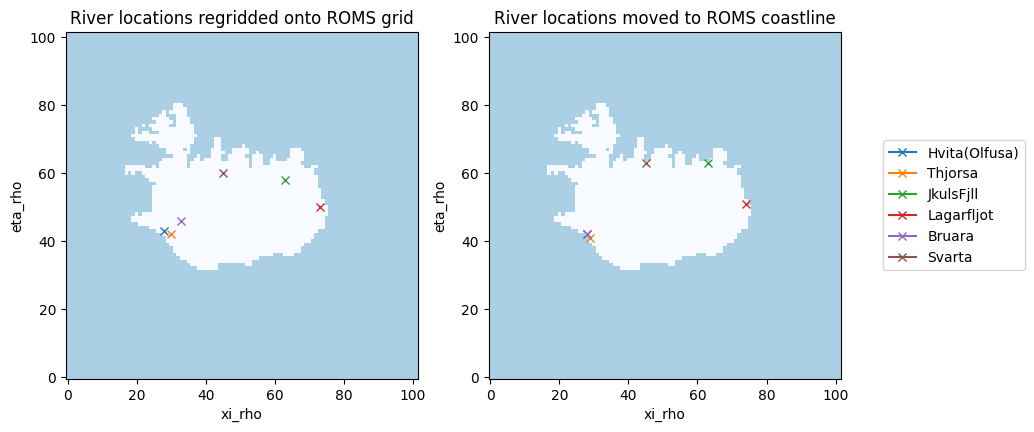

In [463]:
plot_river_locations(coarse_grid)

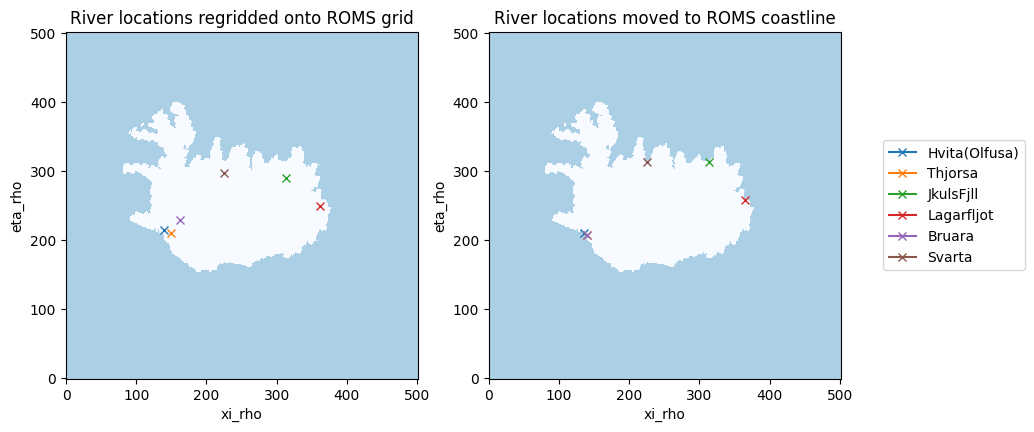

In [464]:
plot_river_locations(fine_grid)

## ROMS river forcing

In [472]:
ds = xr.Dataset()

In [480]:
def create_river_forcing(grid, ds_sub, eta_index, xi_index):
    river_flux = xr.zeros_like(grid.ds.mask_rho) * ds_sub.time

    for i in range(len(eta_index)):
        eta, xi = eta_index[i], xi_index[i]
        
        river_flux[eta, xi] = (ds_sub["FLOW"] * ds_sub["ratio_m2s"]).isel(station=i)

    ds["river_flux"] = river_flux

    return ds

In [481]:
ds_sub, eta_index, xi_index, updated_eta_index, updated_xi_index = extract_river_indices(coarse_grid)

In [482]:
ds = create_river_forcing(coarse_grid, ds_sub, updated_eta_index, updated_xi_index)

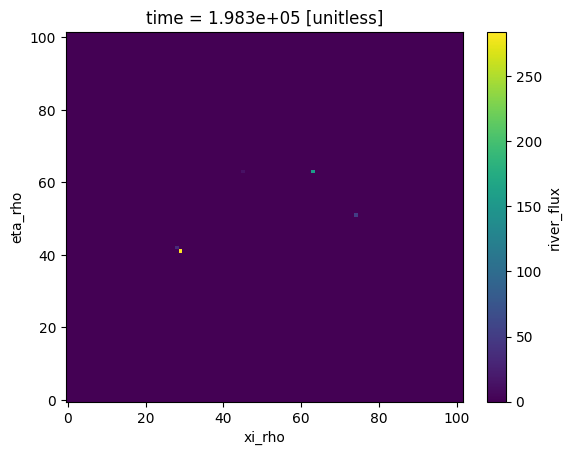

In [486]:
ds.river_flux.isel(time=1000).plot()

In [466]:
ds_sub

<xarray.Dataset> Size: 700kB
Dimensions:        (station: 6, chars: 30, time: 1428, station_1800: 11,
                    time_1800: 2412)
Coordinates:
  * time           (time) float64 11kB 1.9e+05 1.9e+05 ... 2.018e+05 2.018e+05
  * station        (station) float64 48B 226.0 236.0 312.0 389.0 582.0 796.0
  * chars          (chars) int32 120B -2147483647 -2147483647 ... -2147483647
  * time_1800      (time_1800) int32 10kB 180001 180002 180003 ... 200011 200012
  * station_1800   (station_1800) int32 44B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/21)
    id             (station) float64 48B 9.774e+03 9.772e+03 ... 7.722e+03
    lon            (station) float32 24B -21.0 -20.63 -16.42 -14.37 -20.52 -19.4
    lat            (station) float32 24B 63.94 63.93 65.83 65.5 64.25 65.5
    lon_mou        (station) float32 24B 339.0 339.4 343.6 345.6 339.5 340.6
    lat_mou        (station) float32 24B 63.94 63.93 65.83 65.5 64.25 65.5
    area_stn       (station) float32 24B 5.76e+03 7.2e+03 7e+03 ... 225.0 390.0
    ...             ...
    riv_name       (station, chars) object 1kB b'H' b'v' b'i' ... nan nan nan
    ocn_name       (station, chars) object 1kB b'A' b'T' b'L' ... nan nan nan
    stn_name       (station, chars) object 1kB b'S' b'e' b'l' ... nan nan nan
    FLOW           (time, station) float32 34kB nan nan nan nan ... nan nan nan
    index_id_1800  (station_1800, station) float64 528B 20.0 20.0 ... 474.0
    FLOW_1800      (time_1800, station_1800, station) float32 637kB nan ... nan
Attributes:
    creation_date:  Tue Apr 23 09:08:17 EDT 2019 by tqian
    Conventions:    NCAR
    source_file:    coastal-stns-Vol-monthly.nc + grdc.2004 Updates (Note: 4 ...
    title:          Coastal stns vol. monthly series

In [468]:
riv_flx

<xarray.DataArray (time: 1428, station: 6)> Size: 34kB
array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 11kB 1.9e+05 1.9e+05 1.9e+05 ... 2.018e+05 2.018e+05
  * station  (station) float64 48B 226.0 236.0 312.0 389.0 582.0 796.0

In [ ]:
def validate_rivers(grid, 

In [443]:
riv_lon = ds_sub["lon_mou"]

In [444]:
riv_lat = ds_sub["lat_mou"]

In [445]:
riv_vol = ds_sub["vol_stn"] * ds_sub["ratio_m2s"]